In [1]:
import numpy as np
from PIL import Image
import os

PATH = './images/images/architecure/'

In [ ]:
from google.colab import files
files.upload()

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d duttadebadri/image-classification

100% 2.34G/2.34G [00:47<00:00, 64.8MB/s]
100% 2.34G/2.34G [00:47<00:00, 53.2MB/s]


In [6]:
# unzip the dataset
!unzip -q image-classification.zip

# remove the zip file
!rm image-classification.zip

In [7]:
# build random gaussian
def random_gaussian(mean, std):
    # generate two random number and subtract from 1 to make it between 0 and 1
    u1 = 1.0 - np.random.uniform(0.0, 1.0)
    u2 = 1.0 - np.random.uniform(0.0, 1.0)
    # Calculate the z-value using the Box-Muller transform.
    z = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)
    # Scale the z-value by the standard deviation and add the mean to get the desired random number.
    return z * std + mean

In [8]:
# add gaussian noise to image
def add_gaussian_noise(image, mean, std_dev):
    # get width and height of image
    w, h = image.size
    # Load the pixel data of the image
    pixels = np.array(image)

    # Iterate over each pixel in the image
    for x in range(w):
        for y in range(h):
            # Get the RGB values of the current pixel
            r, g, b = pixels[x, y]

            # Generate and add random noise values for each RGB channel
            r += random_gaussian(mean, std_dev)
            g += random_gaussian(mean, std_dev)
            b += random_gaussian(mean, std_dev)

            # Add the generated noise to the RGB values
            r = int(max(0, min(255, r)))
            g = int(max(0, min(255, g)))
            b = int(max(0, min(255, b)))

            # Update the pixel values with the modified RGB values
            pixels[x, y] = (r, g, b)

    return Image.fromarray(pixels)


In [9]:
# # Load image
# image = Image.open("image.jpg")

# noisy_image = add_gaussian_noise(image, 0, 50)

# # Save the noisy image
# noisy_image.save("noisy.jpg")

In [10]:
# Calculate biggest eigenvalue and eigenvector
def power_iteration(matrix, simulations=100):
    # Choose a random initial vector
    b_k = np.random.rand(matrix.shape[1])

    for _ in range(simulations):
        # Compute the matrix-by-vector product Ab
        b_k1 = np.dot(matrix, b_k)

        # Compute the norm
        b_k1_norm = 0
        for e in b_k1:
            b_k1_norm += e ** 2

        b_k1_norm = np.sqrt(b_k1_norm)

        # Re-normalize the vector
        b_k = b_k1 / b_k1_norm

    # Compute and return the largest eigenvalue and its corresponding eigenvector
    return np.dot(np.dot(matrix, b_k), b_k) / np.dot(b_k, b_k), b_k

In [11]:
# calculate all eigenvalues and eigenvectors
def compute_eigen_values_vectors(matrix, simulations=100):
    # Get the size of the matrix
    n = matrix.shape[0]
    # Initialize the eigenvectors and eigenvalues
    values = np.zeros(n)
    vectors = np.zeros((n, n))

    for i in range(n):
        # Compute the largest eigenvalue and its corresponding eigenvector using power iteration
        val, vec = power_iteration(matrix, simulations)

        # Store the computed eigenvalue and eigenvector
        values[i] = val
        vectors[:, i] = vec

        # Deflate the matrix by subtracting the rank-one matrix formed by the outer product of the eigenvector and itself
        matrix = matrix - val * np.outer(vec, vec)

    return values, vectors

In [12]:
# calculate SVD
def SVD(matrix):
    # calculate eigen values and eigen vectors
    eigen_values, eigen_vectors = compute_eigen_values_vectors(np.dot(matrix.T, matrix))
    # sort eigen values and eigen vectors

    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]
    # calculate SVD
    S = np.sqrt(eigen_values)
    V = eigen_vectors
    U = matrix.dot(V) / S
    return U, S, V.T

In [13]:
# denoising using SVD
def svd_denoising_per_channel(matrix, singular):
    U, S, V_t = SVD(matrix)
    denoise_channel = np.dot(U[:, :singular], np.dot(np.diag(S[:singular]), V_t[:singular, :]))
    denoise_channel = np.clip(denoise_channel, 0, 255).astype(np.uint8)
    return Image.fromarray(denoise_channel)


In [22]:
# denoise image with rgb channel
def svd_denoising(image, singular):
    # Convert the image to a numpy array
    img_arr = np.array(image).astype(np.float64)

    # Split the image into its three channels
    R, G, B = img_arr[:, :, 0], img_arr[:, :, 1], img_arr[:, :, 2]

    r = svd_denoising_per_channel(R, singular)
    g = svd_denoising_per_channel(G, singular)
    b = svd_denoising_per_channel(B, singular)

    return Image.merge('RGB', (r, g, b))

In [15]:
# denoised_image = svd_denoising('noisy.jpg', singular=100)
# denoised_image.save('denoised.jpg')

In [31]:
# concatenate images horizontally (actual, noisy, denoised)
def get_concat_h(im1, im2, im3):
    dst = Image.new('RGB', (im1.width + im2.width +  im3.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3, (im1.width + im2.width, 0))
    return dst

<ipython-input-12-ab4ab2decc73>:11: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(eigen_values)



------------------------------------------------------------



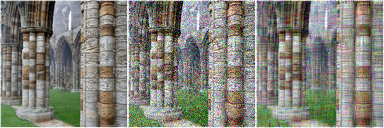



------------------------------------------------------------



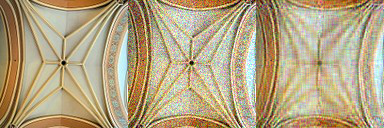



------------------------------------------------------------



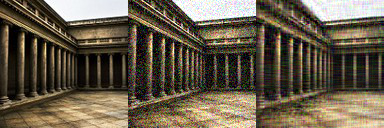



------------------------------------------------------------



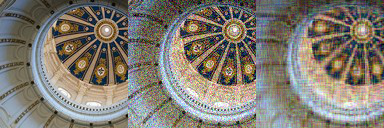



------------------------------------------------------------



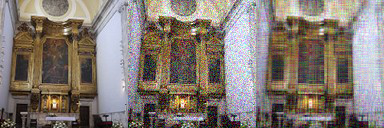



------------------------------------------------------------



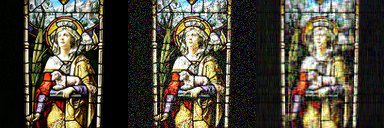



------------------------------------------------------------



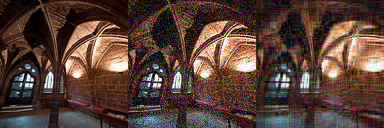



------------------------------------------------------------



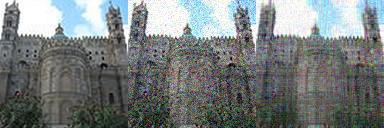



------------------------------------------------------------



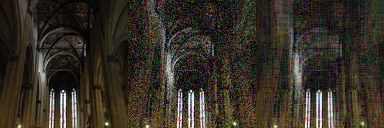



------------------------------------------------------------



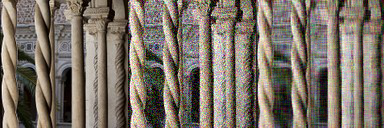

In [40]:
# 10 random sample add noise and denoise
lst = os.listdir(PATH)
for i in range(10):
    path = PATH + np.random.choice(lst)
    image = Image.open(path)
    noisy_image = add_gaussian_noise(image, mean=10, std_dev=30)
    denoised_image = svd_denoising(noisy_image, singular=15)
    print()
    print("------------------------------------------------------------")
    print()
    get_concat_h(image, noisy_image, denoised_image).show()
    print()

<ipython-input-12-ab4ab2decc73>:11: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(eigen_values)



------------------------------------------------------------



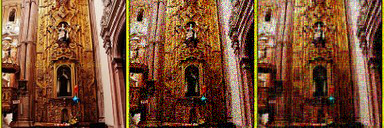



------------------------------------------------------------



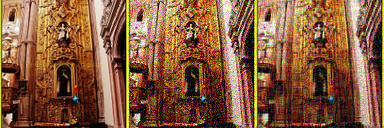



------------------------------------------------------------



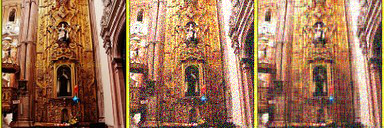



------------------------------------------------------------



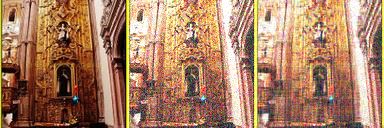

In [41]:
# comapare effect of mean
lst = os.listdir(PATH)
path = PATH + np.random.choice(lst)
image = Image.open(path)

mean_vals = [-20, 0, 40, 60]

for i in mean_vals:
    noisy_image = add_gaussian_noise(image, mean=i, std_dev=30)
    denoised_image = svd_denoising(noisy_image, singular=25)
    print()
    print("------------------------------------------------------------")
    print()
    get_concat_h(image, noisy_image, denoised_image).show()
    print()

<ipython-input-12-ab4ab2decc73>:11: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(eigen_values)



------------------------------------------------------------



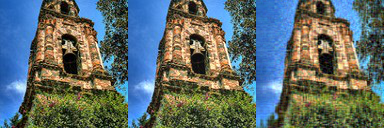



------------------------------------------------------------



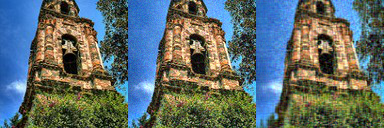



------------------------------------------------------------



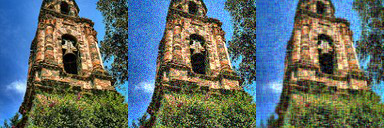



------------------------------------------------------------



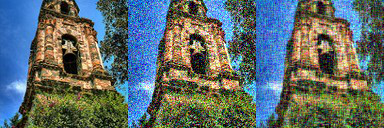



------------------------------------------------------------



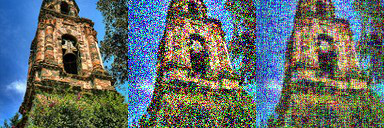

In [42]:
# comapare effect of standard deviation
lst = os.listdir(PATH)
path = PATH + np.random.choice(lst)
image = Image.open(path)

std_vals = [0, 10, 20, 40, 80]

for i in std_vals:
    noisy_image = add_gaussian_noise(image, mean=10, std_dev=i)
    denoised_image = svd_denoising(noisy_image, singular=25)
    print()
    print("------------------------------------------------------------")
    print()
    get_concat_h(image, noisy_image, denoised_image).show()
    print()

<ipython-input-12-ab4ab2decc73>:11: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(eigen_values)



------------------------------------------------------------



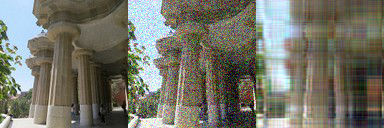



------------------------------------------------------------



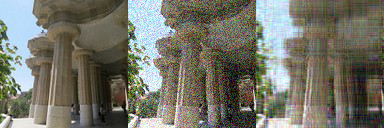



------------------------------------------------------------



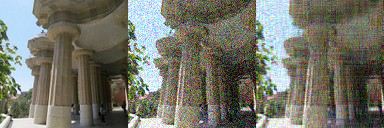



------------------------------------------------------------



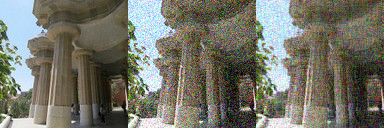



------------------------------------------------------------



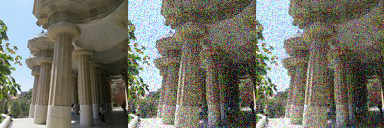

In [44]:
# comapare effect of singular values
lst = os.listdir(PATH)
path = PATH + np.random.choice(lst)
image = Image.open(path)

sing_vals = [5, 10, 20, 30, 50]

for i in sing_vals:
    noisy_image = add_gaussian_noise(image, mean=10, std_dev=30)
    denoised_image = svd_denoising(noisy_image, singular=i)
    print()
    print("------------------------------------------------------------")
    print()
    get_concat_h(image, noisy_image, denoised_image).show()
    print()